<h1><center> Model to predict SIT error at a local point </center></h1>

Goal: predict the error at a specific point.


Clean version of the $local\_model$ notebook. The $local\_model$ notebook has been left because it contains all the results, but this new notebook has been greatly improved (especially in the database construction). Ideally, it is better not to use the other notebook, which is a mess and may not have all the required codes.

## Load data to build dataset

In [1]:
%load_ext autoreload
%autoreload 1
%reload_ext autoreload


%aimport src.utils.tardisml_utils

In [2]:
import os
import yaml
import pickle as pkl
import netCDF4 as nc4

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

login-2.fram.sigma2.no
fram detected
login-2.fram.sigma2.no
fram detected
login-2.fram.sigma2.no
fram detected
login-2.fram.sigma2.no
fram detected


In [3]:
# Load configuration

# Date to plot in example
idate = 100
# Path to config file
file_config = '../config/data_proc_demo.yaml'
# Path to template file
file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template), Loader=yaml.FullLoader)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)

In [4]:
# Get data and compute pcas, eofs

# Chronology
# (the same for all forcing fields, just take the first one)
df = pd.read_pickle(os.path.join(rootdir,forcing_bdir,f'mslprs.pkl'))
chrono = df[df.time%1==timeofday].date

# Load landmask
mskok1d, mskok = load_data.get_land_mask(lim_idm, lim_jdm, rootdir, pca_dir)

# Loading error of Target var PCA SIT assimilation - no assimilation
data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)

# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_SITerr.nc")
Xe, mu_e, RMSE_e = load_data.load_nc(filename, target_field)

# Reconstruction from PCA
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_SITerr.pkl")
pca_e = load_data.load_pca(filename)
PCs_e = feature_pca.pca_to_PC(pca_e, Xe, mskok1d)
EOF1d_e, EOF2d_e = feature_pca.compute_eof(n_components, Xe, pca_e, mskok)
Xe_rec = xr.dot(EOF2d_e,PCs_e) + mu_e


# Load forecast values
data_dir = nosit_dir
list_files = feature_pca.missing_file(chrono, data_dir, template)
nc_f = xr.open_mfdataset(list_files, combine='nested', concat_dim='rdim')

forcing_fields = ["airtmp", "mslprs", "wndewd"]
#forcing_fields = ["airtmp", "dewpt", "mslprs", "nlwrad", "nswrad", "precip", "radflx", "shwflx", "vapmix", "wndewd", "wndnwd"]
forcing_fields = [f + "_mean21d" for f in forcing_fields]

#Load forcing values
forcings = dict()
filepath = os.path.join(rootdir, forcing_bdir)
for field in forcing_fields:
    forcings[field] = np.load(f'{filepath}/{field}.npy')
Nf = len(forcing_fields) # Number of forcing fields

Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hice00_4N_SITerr.pkl



Version non récursive :
input : covar, forcings + sit f pr 8 points autour + 2 

## Build datasets

In [5]:
import tensorflow as tf

2022-09-13 13:44:03.520341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 13:44:03.520375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
def plot_points(points):
    fig, ax = plt.subplots()
    for i, point in enumerate(points):
        if len(points) > 1:
            ax.text(point[0], point[1], i+1, color='r')
        else:
            ax.plot(point[0], point[1], marker='.', color='r')
    mskok.plot(ax=ax, cmap=plt.cm.Blues)

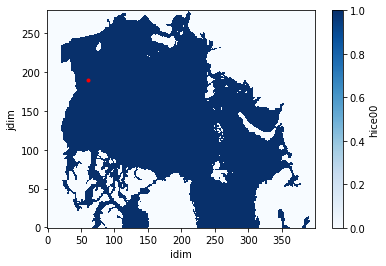

In [7]:
point = (60, 190) # x, y
t = Xe.shape[0]
Xe_pt = Xe[:, point[1], point[0]]
plot_points([point])

In [8]:
# Xf_rec point                :   t-1      t     t+1
# chaque forcing point        :  t-365   t-100    t
# chaque covar point          :    t
# chaque forcing point autour :  t-365   t-100    t
# chaque covar point autour   :    t

#Xf_sel_cov.keys(), X_sel_fgs.keys()

In [9]:
def to_np_array(data, keep=[]):
    """ Convert data type from xarray.core.dataarray.DataArray to numpy.ndarray
    As the xarray's .sel() operation is really long, it's better to use the np array way of selecting points in get_area().
    In:
        data        : xarray.core.dataarray.DataArray  -- Data to process
        keep        : String list                      -- Parameters values to keep in data
        
    Out:
        X_sel       : numpy.ndarray dict -- data with np type
    """
    npa_data = dict()
    
    for f in keep:
        npa_data[f] = np.array(data[f])

    return npa_data

def get_area(data, lim_idm, lim_jdm):
    """ Keep only data for the given geographical zone
    In:
        data        : numpy.ndarray  -- Data to process
        lim_idm     : tuple          -- limits of the geographical area to be preserved (following axes x)
        lim_jdm     : tuple          -- limits of the geographical area to be preserved (following axes y)
        
    Out:
        X_sel       : dict -- key = field name, value = (y, x) array, data array restricted to the given geographical area and mean over time, reversed data if rev
    """
    
    X_sel = dict()
    
    for field in data.keys():
        X_sel[field] = data[field][:, lim_jdm[0]:lim_jdm[1], lim_idm[0]:lim_idm[1]]

    return X_sel


def keep_nonan(data, index_mask, keep=[]):
    """ Keep only masked values (index_mask), corresponding to the land where SIT data is available (nonNaN)
    """
    X_sel_nonan = dict()
    
    t = 1461
    n = index_mask.shape[1]
    
    for f in keep:
        X_sel_nonan[f] = np.array([data[f][time, index_mask[0], index_mask[1]] for time in range(t)])

    return X_sel_nonan

In [10]:
def scale_data(train_data, test_data):
    max_val = train_data.max()
    min_val = train_data.min()
    train_scaled = (train_data - min_val) / (max_val - min_val)
    test_scaled = (test_data - min_val) / (max_val - min_val)
    return train_scaled, test_scaled

def build_dataset_1pt(point, cov_sel, fgs, Y, chrono, exclude_cov=[], keep_fg=[], size_around=0, train_p=3/4, val_p=0, times=[0]):
    """ Construct the NN dataset of a single point.
    
    In: 
        point       : int list           --  (i, j) coordinates of the point for which we want to calculate the dataset
        cov_sel     : numpy.ndarray dict -- dict containing (t, y, x) data for each choosen covariables. Need to keep ilim/jlim values for x:y!
        fgs         : numpy.ndarray dict -- dict containing (t, y, x) data for each forcings (supposed to be already scale)
        Y           : numpy.ndarray      -- (t), error time serie for the chosen point
        chrono      : 
        exclude     : String list        -- if want to exclude some covariables values
        keep_fg     : String list        -- list of the forcing to keep in the dataset
        size_around : int                -- number of points around to include in the database (if size_around=n, in total we keep data for (n*2+1)^2)
        train_p     : float              -- proportion of data in the training set
        val_p       : float              -- proportion of data in the validation set
        times       : int list           -- allows to include different time steps in an input data (for LSTM). Each element corresponds to the time lag to be given
                                            - if times==[0] (DNN mode) : shape X data (n, nb_param)
                                            - else          (LSTM mode): shape X data (n, len(times), nb_param) -> the number of data is reduced here because the extreme data do not have the necessary lag data and are therefore removed
        
    Out:
        dataset            : dict            -- NN data (Y: wanted output / X: given input)
                                                Xtest, ytest : test data 
                                                Xtrain, ytrain : train data
                                            
        (n, ntrain, ntest) : (int, int, int) -- size of the differents dataset (n=ntrain+ntest)
        rchrono            :                 -- len(rchrono) = n, times associated to the dataset (usefull for LSTM as it's cut)

    """
    
    keep_cov = [c for c in cov_sel.keys() if c not in exclude_cov]
    
    t = cov_sel[keep_cov[0]].shape[0]
    nb_pts = pow((size_around)*2 + 1, 2)
    
    if size_around == 0:
        nb_params = len(keep_cov) + len(keep_fg)
    else:
        nb_params = (len(keep_cov) + len(keep_fg))*nb_pts
        
    X = np.empty([t, nb_params])
    
    # Get the data for the point
    if size_around == 0:
        for ind_f, f in enumerate(keep_cov):
            cov_pt = cov_sel[f][:, point[1], point[0]]
            #if np.isnan(cov_pt).any():
            #    return np.nan
            #else:
            X[:, ind_f] = cov_pt

        for ind_f, f in zip(range(len(keep_fg), nb_params), keep_fg):
            fg_pt = fgs[f][:, point[1], point[0]]
            #if np.isnan(fg_pt).any():
            #    return np.nan
            #else:
            X[:, ind_f]= fg_pt
            
    else: # TODO : size around aux bords lol
        for ind_f, f in enumerate(keep_cov):
            cov_pt = cov_sel[f][:, point[1]-size_around:point[1]+size_around+1, point[0]-size_around:point[0]+size_around+1]
            #if np.isnan(cov_pt).any():
            #    return np.nan
            #else:
            X[:, ind_f*nb_pts:(ind_f+1)*nb_pts] = np.reshape(cov_pt, (t, nb_pts))

        for ind_f, f in zip(range(len(keep_fg), len(keep_cov)+len(keep_fg)), keep_fg):
            fg_pt = fgs[f][:, point[1]-size_around:point[1]+size_around+1, point[0]-size_around:point[0]+size_around+1]
            #if np.isnan(fg_pt).any():
            #    return np.nan
            #else:
            X[:, ind_f*nb_pts:(ind_f+1)*nb_pts] = np.reshape(fg_pt, (t, nb_pts))
            
    # If need differents times
    needfutur, needpast = 0, 0
    if max(times)>0:
        needfutur = max(times)
    if min(times)<0:
        needpast = abs(min(times))
        
    # Number of data
    n = X.shape[0] - needpast - needfutur
        
    if len(times) > 1:
        # 3D dataset for LSTM (alltimes,timeslagsgiven, allfeatures) (add several time step in input)
        X2 = np.empty([n, len(times), nb_params])
        for time in range(n):
            for i, ts in enumerate(times):
                X2[time, i] = X[needpast+time+ts]
        X = X2
   

    # Train/Test/Validation set
    ntrain = int(n*train_p)
    nval = int(n*val_p)
    ntest = int(n - ntrain - nval)

    
    # Split dataset, train with older years
    # X = (t1_pt1,  ..., tn_pt1, t1_pt2, ..., tn_ptn)
    dataset = dict()
    Xtrain = X[ntest:]

    #Xval = X[]
    #dataset["yval"] = Y[]
    Xtest = X[:ntest]
    dataset["ytest"] = Y[needpast:ntest+needpast]
    
    if len(times) > 1:
        Xtrain = np.reshape(Xtrain, [ntrain, len(times), nb_params])
        Xtest = np.reshape(Xtest, [ntest, len(times), nb_params])
        dataset["ytrain"] = Y[ntest+needpast:-needfutur]

    else:
        dataset["ytrain"] = Y[ntest:]

    
    # Add noise to avoid overfitting
    Xtrain = Xtrain + np.random.normal(0, np.std(Xtrain) / 1000, Xtrain.shape)
    dataset["Xtrain"], dataset["Xtest"] = scale_data(Xtrain, Xtest)
          
    rchrono = chrono[needpast:-needfutur] if needfutur > 0 else chrono[needpast:]
    
    return dataset, (n, ntrain, ntest), rchrono

### Train the model

In [11]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [12]:
def plot_training_analysis(history):
    loss = history.history['loss']
    r2 = history.history['r_square']
    rmse = history.history['root_mean_squared_error']

    epochs = range(len(loss))

    plt.plot(epochs, rmse, 'b', linestyle="--",label='Training rmse')
    plt.plot(epochs, r2, 'g', linestyle="--",label='Training r2')
    plt.plot(epochs, loss, 'r', linestyle="--",label='Training loss')
    plt.title('Training stats')
    plt.legend()

    plt.show()
    

def print_res(model, dataset, batch_size=128, ens="test"):
    res = model.evaluate(dataset[0][f"X{ens}"], dataset[0][f"y{ens}"], batch_size=batch_size, verbose=0)
    for i, m in enumerate(model.metrics_names):
        print(f"{m} : {res[i]}")
    
    
def draw(model, x, y, chrono, ntest, twin=False):
    fig, ax = plt.subplots(figsize=(12,10))
    l1 = ax.plot(chrono, y, label='true error')
    if twin:
        ax_twin = ax.twinx()
        l2 = ax_twin.plot(chrono, model.predict(x), label='prediction', color='orange')
    else:
        l2 = ax.plot(chrono, model.predict(x), label='prediction')
    lab1 = l1+l2
    lab2 = [l.get_label() for l in lab1]
    plt.legend(lab1, lab2)
    plt.axvline(x=chrono.iloc[ntest], linestyle='dotted', color='grey', label='train limit')

In [13]:
def lauch_train(model, dataset, epochs=250, batch_size=128, print_arch_model=True, print_history=True, plot_draw=True):

    if print_arch_model:
        model.summary()
        plt.show()
        
    history = model.fit(dataset[0]["Xtrain"], dataset[0]["ytrain"], epochs=epochs, batch_size=batch_size, verbose=0)

    if print_history:
        plot_training_analysis(history)
        plt.show()

    if plot_draw:
        draw(model, np.concatenate((dataset[0]["Xtest"], dataset[0]["Xtrain"])), np.concatenate((dataset[0]["ytest"], dataset[0]["ytrain"])), dataset[2], dataset[1][2])
        plt.show()

    print_res(model, dataset)
    
    return model

In [14]:
import tensorflow_addons as tfa

def DNN_model(input_shape):
       
    inp = Input(shape=(input_shape))
    x = Dense(128, activation='relu')(inp)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    
    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])
    
    return model

def LSTM_model(timesteps, features, units=30):
    
    model = Sequential()
    model.add(LSTM(units = units, return_sequences = True, input_shape = (timesteps, features)))
    model.add(Dropout(0.1))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.1))

    model.add(LSTM(units = units))
    model.add(Dropout(0.1))

    model.add(Dense(units = 1))

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])

    
    return model

def CNN_model(timesteps, features):
    
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', input_shape=(timesteps, features)))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(units = 1))

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])

    
    return model

In [15]:
# dict of Keras models
models = dict()
# dict of datasets, one dataset = ({"Xtrain", "ytrain", "Xtest", "ytest"}, (n, ntrain, ntest), chrono)
datasets = dict()

In [16]:
keep_cov = ["hice00", "hsnw00"]
keep_fgs = []

In [17]:
np_cov = to_np_array(nc_f, keep=keep_cov)
np_cov_sel = get_area(np_cov, lim_idm, lim_jdm)

## Train+test on a single point

In [39]:
forcings.keys()

dict_keys(['airtmp_mean21d', 'mslprs_mean21d', 'wndewd_mean21d'])

In [18]:
# Simple input : SIT forecast for 1 point
datasets["simple_dataset"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, exclude_cov=["hsnw00"], keep_fg=keep_fgs, size_around=0)
datasets["simple_dataset_lstm"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, exclude_cov=["hsnw00"], keep_fg=keep_fgs, size_around=0, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

In [25]:
datasets["simple_dataset_lstm"][0]['Xtrain'].shape

(1043, 11, 1)

In [23]:
datasets["simple_dataset_lstm"][0]['ytrain'].shape

(1043,)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 128)               256       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


2022-09-07 12:52:51.414028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 12:52:51.414075: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 12:52:51.414431: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-09-07 12:52:51.414859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


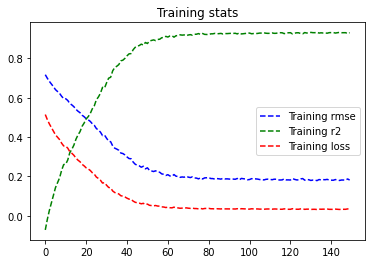

46/46 [==============================] - 0s 1ms/step


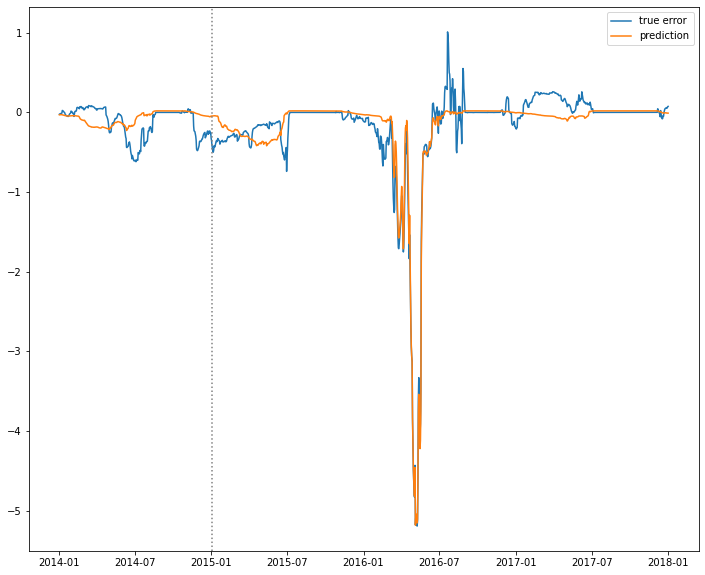

loss : 0.04158250242471695
r_square : -0.16285645961761475
root_mean_squared_error : 0.20391787588596344


In [19]:
# Simple model + simple input
model_name = "dnn_simple"
dataset = "simple_dataset"

model = DNN_model(datasets[dataset][0]["Xtrain"].shape[1])
models[model_name] = lauch_train(model, datasets[dataset], epochs=150, batch_size=128, print_arch_model=True, print_history=True)

2022-09-13 13:51:25.374167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-13 13:51:25.390822: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-13 13:51:25.416958: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-09-13 13:51:25.478943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 11, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 11, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 11, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

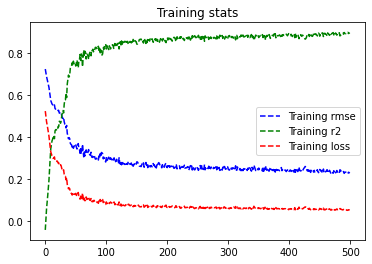

44/44 [==============================] - 3s 4ms/step


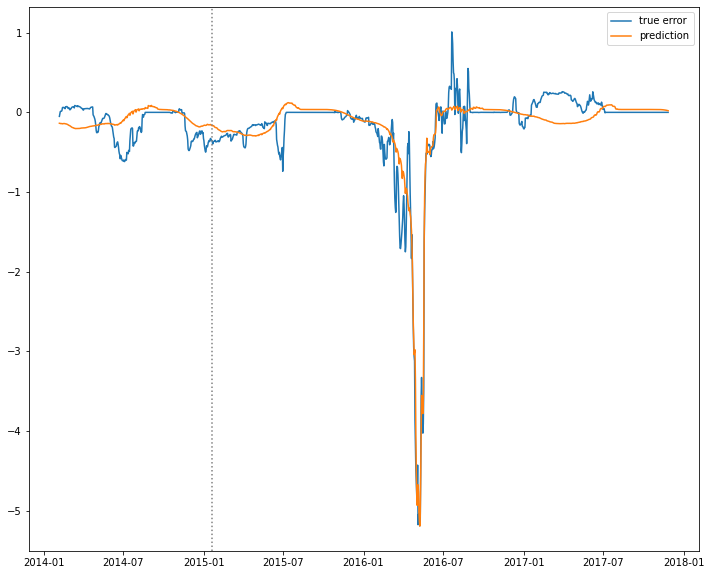

loss : 0.0477910190820694
r_square : -0.19191336631774902
root_mean_squared_error : 0.21861156821250916


In [24]:
# LSTM model + simple input
model_name = "lstm_simple"
dataset = "simple_dataset_lstm"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=500, batch_size=128, print_arch_model=True, print_history=True)

In [34]:
print(f"Picked time : {chrono[250]}\n",
      f' DNN model : {models["dnn_simple"].predict(datasets["simple_dataset"][0]["Xtest"][250:251])}',
      f' LSTM model : {models["lstm_simple"].predict(datasets["simple_dataset_lstm"][0]["Xtest"][150:151])}',
      f' True error : {datasets["simple_dataset"][0]["ytest"][250:251].values}')

1/1 [==============================] - 0s 31ms/step
Picked time : 2014-03-04 12:00:00
  DNN model : [[0.02554007]]  LSTM model : [[-0.22208746]]  True error : [0.]


In [22]:
# More complex input (9pts + hsnow)
datasets["9pts_dataset"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, exclude_cov=[], keep_fg=keep_fgs, size_around=1)
datasets["9pts_dataset_lstm"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, keep_fg=keep_fgs, size_around=1, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

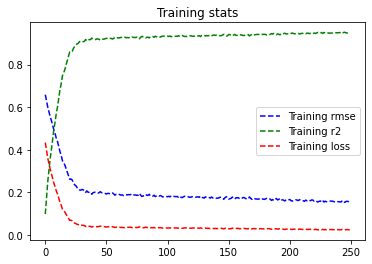

46/46 [==============================] - 2s 2ms/step


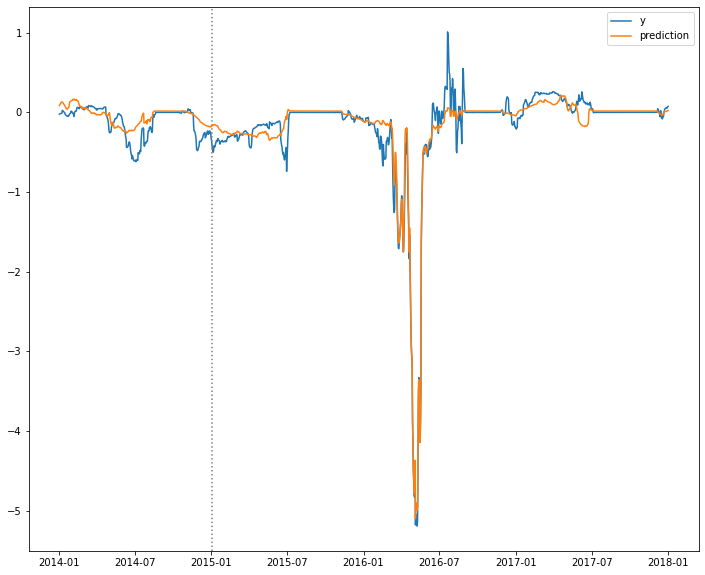

loss : 0.023803848773241043
r_square : 0.3343242406845093
root_mean_squared_error : 0.15428495407104492


In [66]:
# Simple model + more complex input
model_name = "dnn_d2"
dataset = "9pts_dataset"

model = DNN_model(datasets[dataset][0]["Xtrain"].shape[1])
models[model_name] = lauch_train(model, datasets[dataset], epochs=250, batch_size=128, print_arch_model=False, print_history=True)

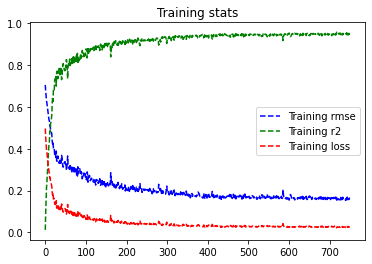

44/44 [==============================] - 3s 4ms/step


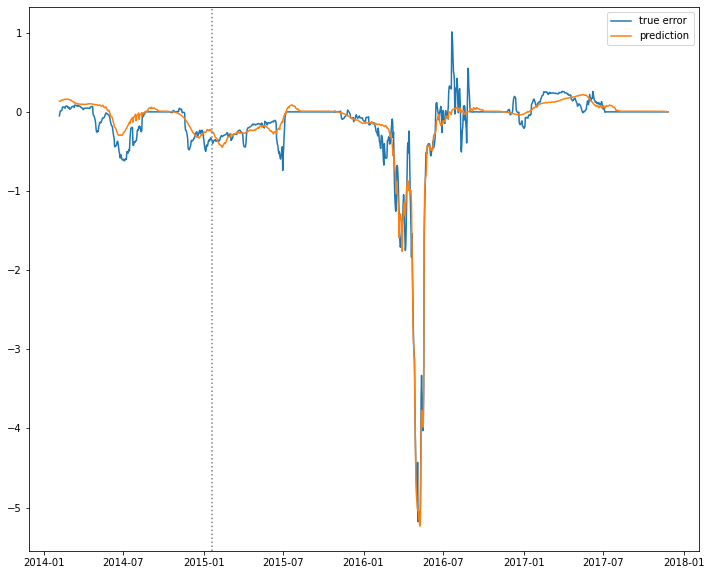

loss : 0.022630803287029266
r_square : 0.43558526039123535
root_mean_squared_error : 0.15043537318706512


In [31]:
# LSTM model + more complex input
model_name = "lstm_d2"
dataset = "9pts_dataset_lstm"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=750, batch_size=128, print_arch_model=False, print_history=True)

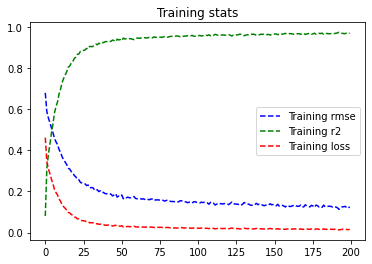

44/44 [==============================] - 0s 1ms/step


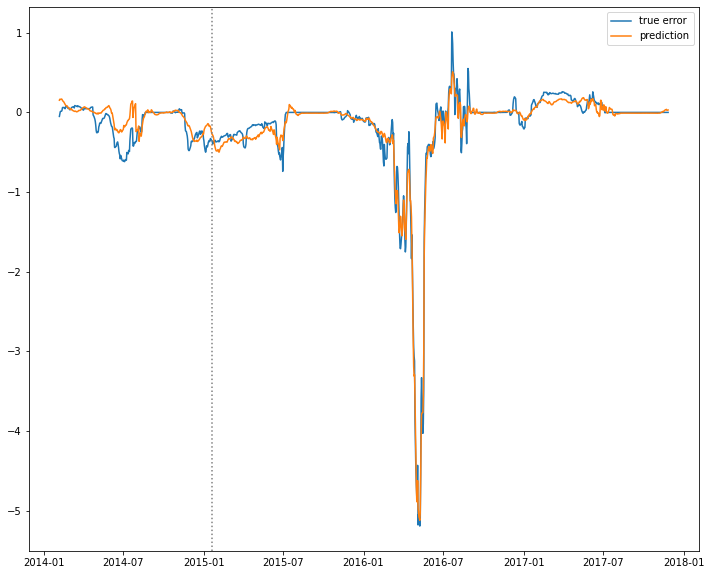

loss : 0.02696630358695984
r_square : 0.3274574279785156
root_mean_squared_error : 0.16421419382095337


In [35]:
# CNN model + more complex input
model_name = "cnn_d2"
dataset = "9pts_dataset_lstm"

model =  CNN_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=200, batch_size=128, print_arch_model=False, print_history=True)

In [37]:
# More points around
datasets["cnn"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, keep_fg=keep_fgs, size_around=4, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

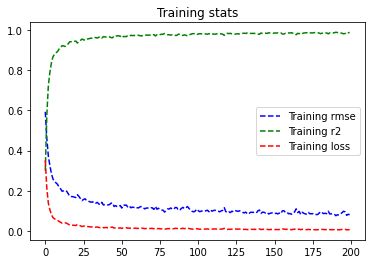

44/44 [==============================] - 0s 1ms/step


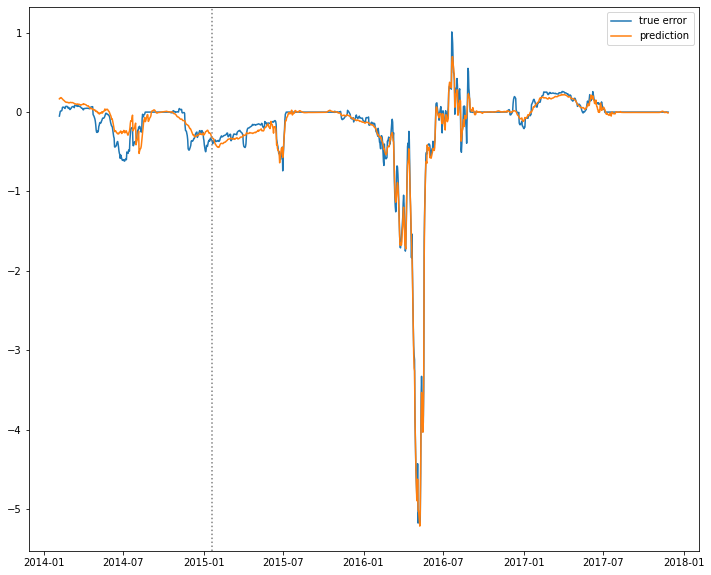

loss : 0.017781030386686325
r_square : 0.5565391778945923
root_mean_squared_error : 0.13334552943706512


In [38]:
# CNN model + more points around
model_name = "cnn_d3"
dataset = "cnn"

model =  CNN_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=200, batch_size=128, print_arch_model=False, print_history=True)

In [41]:
# Even more points around
datasets["cnn2"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, keep_fg=keep_fgs, size_around=16, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

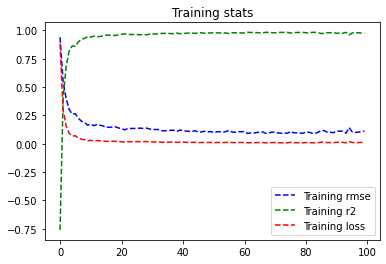

44/44 [==============================] - 2s 4ms/step


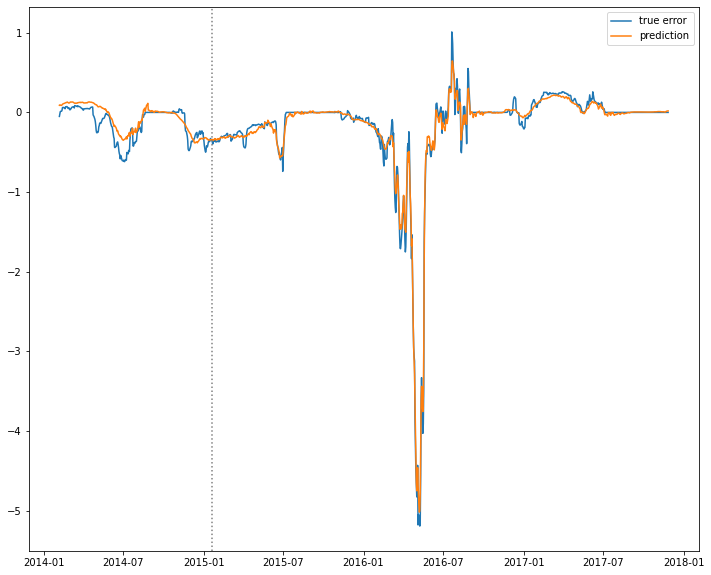

loss : 0.014555541798472404
r_square : 0.6369831562042236
root_mean_squared_error : 0.12064635008573532


In [42]:
# CNN model + more points around
model_name = "cnn_d4"
dataset = "cnn2"

model =  CNN_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=100, batch_size=128, print_arch_model=False, print_history=True)

2022-08-22 09:11:33.175107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-22 09:11:33.213093: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-22 09:11:33.230841: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-08-22 09:11:33.310936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


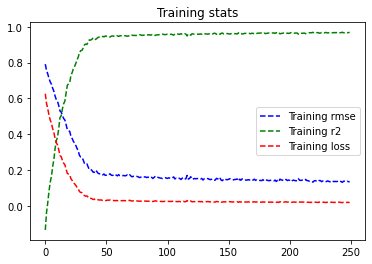

40/40 [==============================] - 2s 920us/step


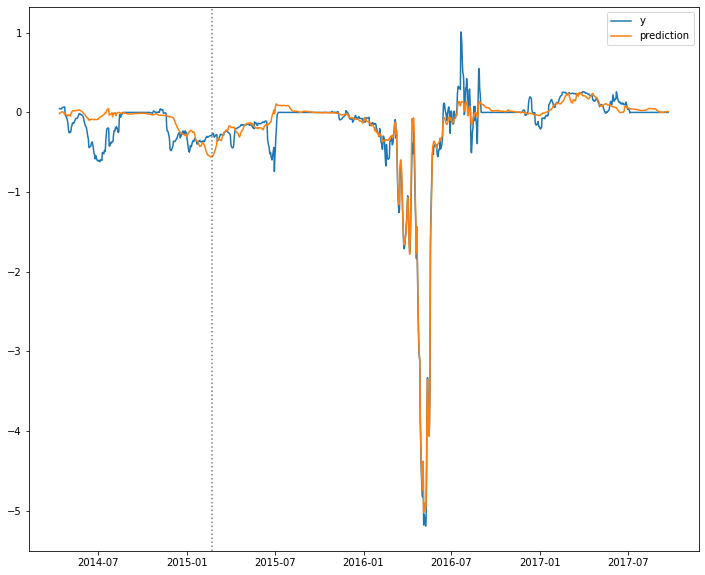

loss : 0.04305446147918701
r_square : -0.16426682472229004
root_mean_squared_error : 0.20749568939208984


In [44]:
# I probably accidentaly deleted the function which do that woops......
#datasets["9pts_dataset_dnn"] =  build_dataset2(xs["9pt_hsnw"], Xe_pt, chrono, train_p=3/4, times=[-100, 0, 100], time_dim=False)

# DNN model with multiple times

#model_name = "dnn_d2_times"
#dataset = "9pts_dataset_dnn"

#model = DNN_model(datasets[dataset][0]["Xtrain"].shape[1])
#models[model_name] = lauch_train(model, datasets[dataset], epochs=250, batch_size=128, print_arch_model=False, print_history=True)

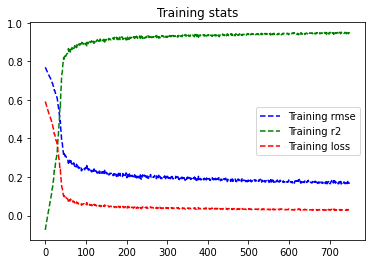

40/40 [==============================] - 3s 2ms/step


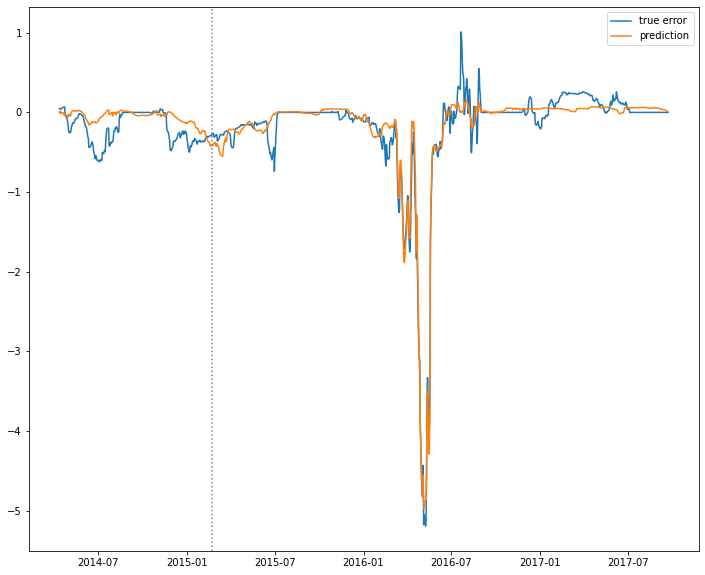

loss : 0.04684922844171524
r_square : -0.26688385009765625
root_mean_squared_error : 0.21644683182239532


In [33]:
datasets["9pts_dataset_lstm_100"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, keep_fg=keep_fgs, size_around=1, times=[-100, 0, 100])

# LSTM model + different chosen time step
model_name = "lstm_d2_100"
dataset = "9pts_dataset_lstm_100"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=750, batch_size=128, print_arch_model=False, print_history=True)

### Train on one point + test on another point

In [35]:
point2 = (205, 130) # x, y
point3 = (60, 200) # x, y

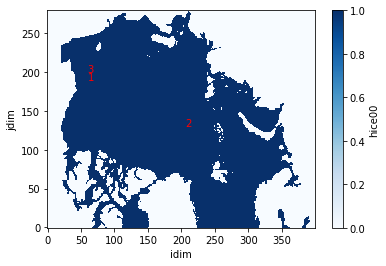

In [36]:
plot_points([point, point2, point3])

In [37]:
Xe_pt2 = Xe[:, point2[1], point2[0]]
Xe_pt3 = Xe[:, point3[1], point3[0]]


datasets["pt2"] = build_dataset_1pt(point2, np_cov_sel, forcings, Xe_pt2, chrono, exclude_cov=[], keep_fg=keep_fgs, size_around=1)
datasets["pt2_lstm"] = build_dataset_1pt(point2, np_cov_sel, forcings, Xe_pt2, chrono, keep_fg=keep_fgs, size_around=1, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

datasets["pt3"] = build_dataset_1pt(point3, np_cov_sel, forcings, Xe_pt3, chrono, exclude_cov=[], keep_fg=keep_fgs, size_around=1)
datasets["pt3_lstm"] = build_dataset_1pt(point3, np_cov_sel, forcings, Xe_pt3, chrono, keep_fg=keep_fgs, size_around=1, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

46/46 [==============================] - 2s 3ms/step
/////////////////////// DNN Test /////////////////////// 
loss : 14.698673248291016
r_square : -439.6574401855469
root_mean_squared_error : 3.8338849544525146
/////////////////////// DNN Train /////////////////////// 
loss : 24.902751922607422
r_square : -237.4801788330078
root_mean_squared_error : 4.990265846252441
44/44 [==============================] - 0s 3ms/step
/////////////////////// LSTM Test /////////////////////// 
loss : 11.365619659423828
r_square : -360.7648620605469
root_mean_squared_error : 3.371293544769287
/////////////////////// LSTM Train /////////////////////// 
loss : 21.08081817626953
r_square : -195.92041015625
root_mean_squared_error : 4.591385364532471


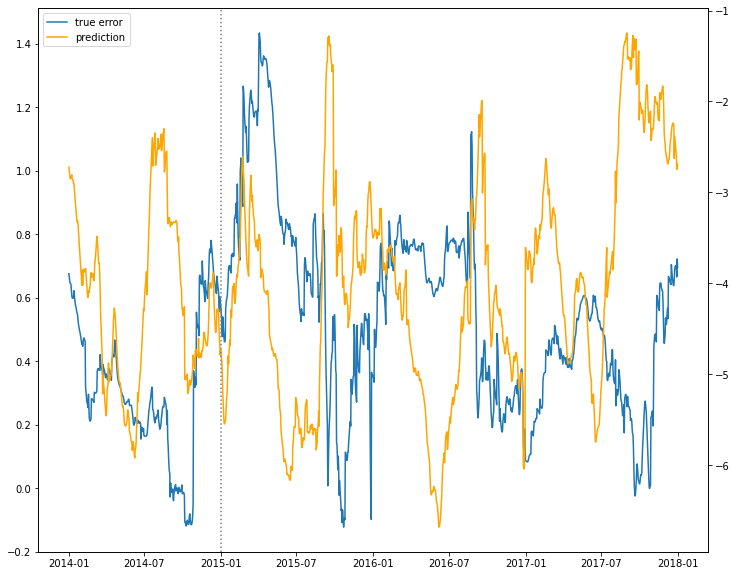

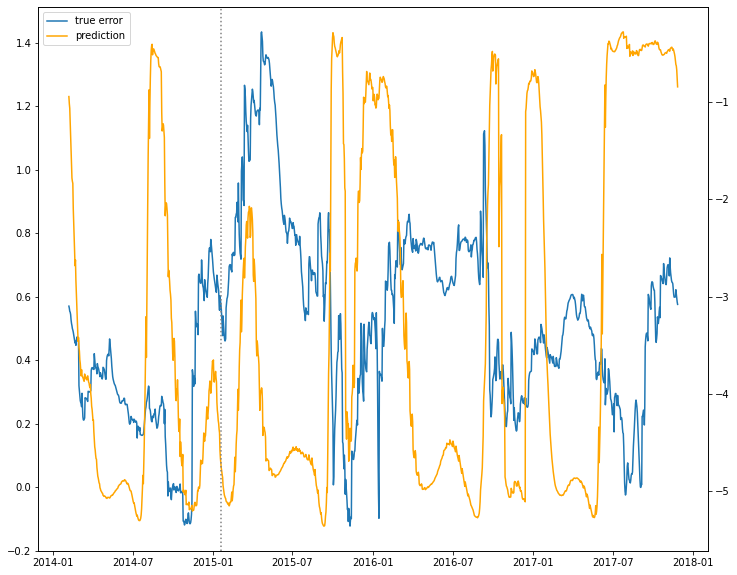

In [38]:
########## Train point1 + Test point2 ##########
# Pt2 + DNN
model_name = "dnn_d2"
dataset = "pt2"

draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"], datasets[dataset][0]["Xtest"])), np.concatenate((datasets[dataset][0]["ytrain"], datasets[dataset][0]["ytest"])), datasets[dataset][2], datasets[dataset][1][2], twin=True)
print("/////////////////////// DNN Test /////////////////////// ")
print_res(models[model_name], datasets[dataset])
print("/////////////////////// DNN Train /////////////////////// ")
print_res(models[model_name], datasets[dataset], ens="train")

# Pt2 + LSTM
model_name = "lstm_d2"
dataset = "pt2_lstm"

draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"], datasets[dataset][0]["Xtest"])), np.concatenate((datasets[dataset][0]["ytrain"], datasets[dataset][0]["ytest"])), datasets[dataset][2], datasets[dataset][1][2], twin=True)
print("/////////////////////// LSTM Test /////////////////////// ")
print_res(models[model_name], datasets[dataset])
print("/////////////////////// LSTM Train /////////////////////// ")
print_res(models[model_name], datasets[dataset], ens="train")

46/46 [==============================] - 0s 884us/step
loss : 1.196324110031128
r_square : -98.25920104980469
root_mean_squared_error : 1.0937659740447998
44/44 [==============================] - 0s 3ms/step
loss : 0.277794748544693
r_square : -11.93841552734375
root_mean_squared_error : 0.5270623564720154


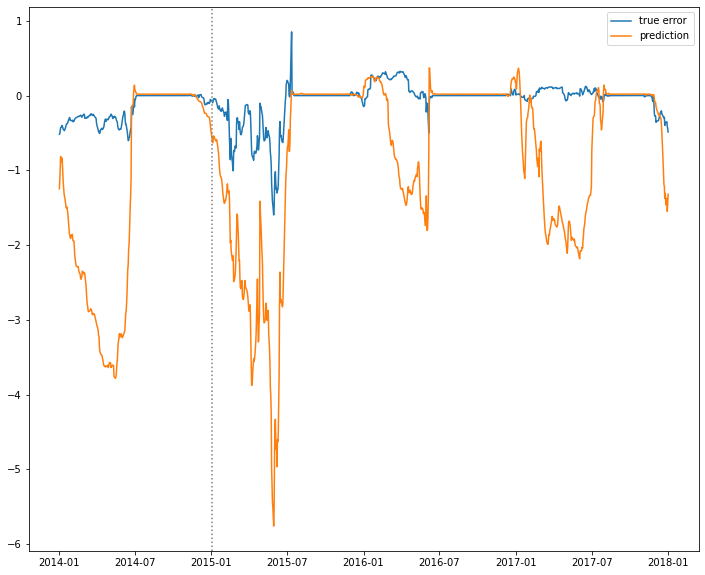

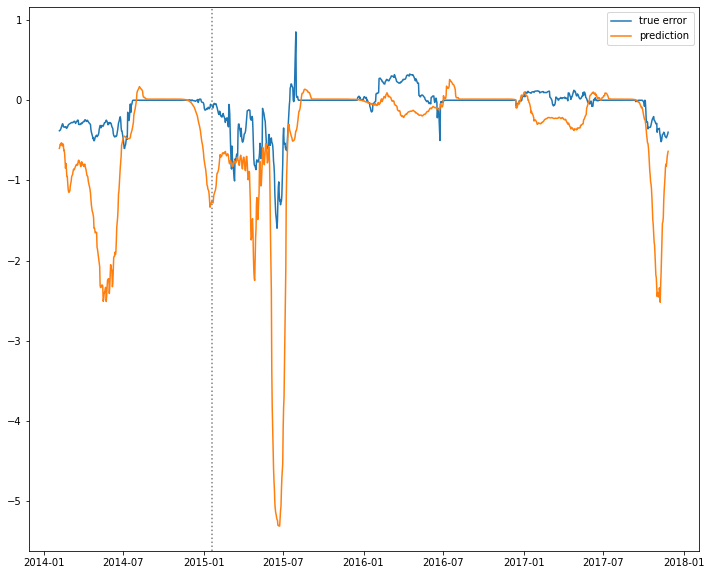

In [39]:
########## Train point1 + Test point3 ##########

# Pt3 + DNN
model_name = "dnn_d2"
dataset = "pt3"

draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"], datasets[dataset][0]["Xtest"])), np.concatenate((datasets[dataset][0]["ytrain"], datasets[dataset][0]["ytest"])), datasets[dataset][2], datasets[dataset][1][2])
print_res(models[model_name], datasets[dataset])


# Pt3 + LSTM
model_name = "lstm_d2"
dataset = "pt3_lstm"

draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"], datasets[dataset][0]["Xtest"])), np.concatenate((datasets[dataset][0]["ytrain"], datasets[dataset][0]["ytest"])), datasets[dataset][2], datasets[dataset][1][2])
print_res(models[model_name], datasets[dataset])

### Train + test on another point (with same model used to predict point 1)

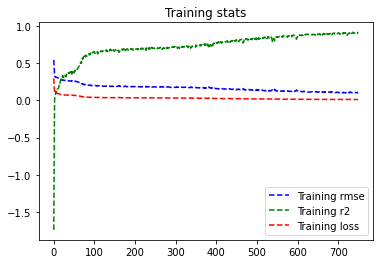

44/44 [==============================] - 3s 3ms/step


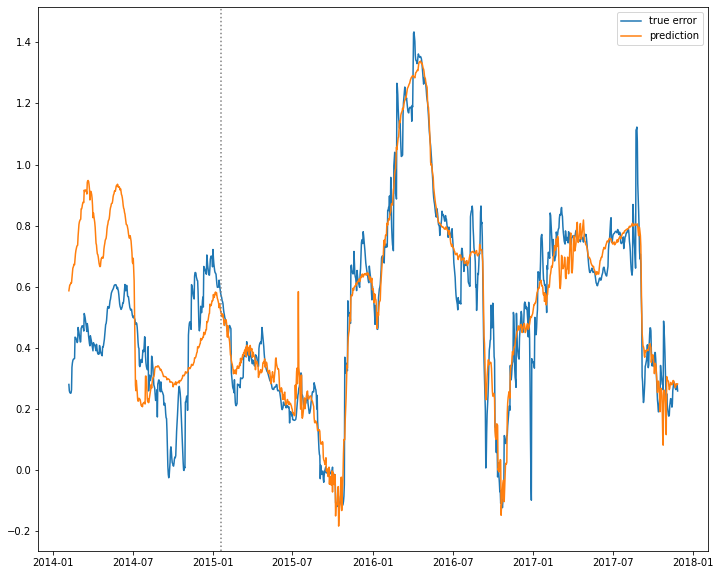

loss : 0.06384249031543732
r_square : -1.032090663909912
root_mean_squared_error : 0.2526707053184509


In [41]:
# LSTM model + more complex input + pt2
model_name = "lstm_d2_pt2"
dataset = "pt2_lstm"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=750, batch_size=128, print_arch_model=False, print_history=True)

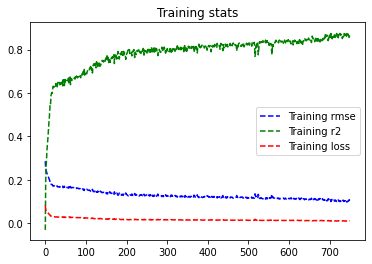

44/44 [==============================] - 4s 4ms/step


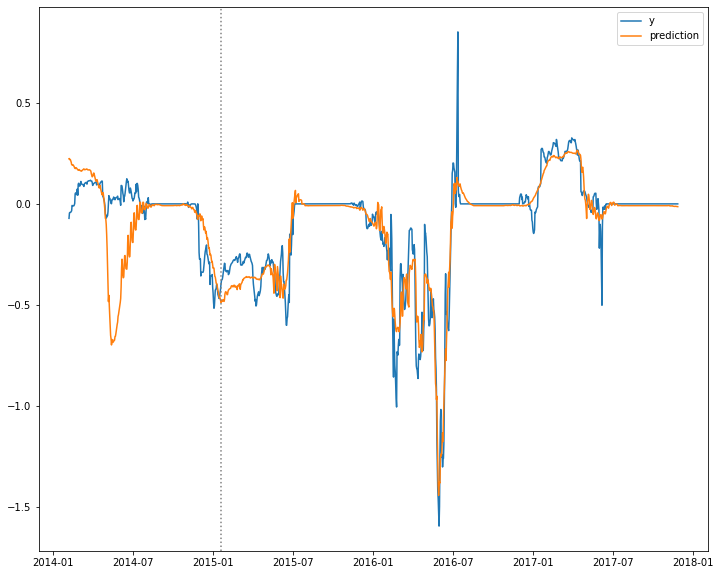

loss : 0.049122460186481476
r_square : -1.287900447845459
root_mean_squared_error : 0.2216358780860901


In [83]:
# LSTM model + more complex input + pt3
model_name = "lstm_d2_pt3"
dataset = "pt3_lstm"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=750, batch_size=128, print_arch_model=False, print_history=True)

### Compute result for all points 

Need to build dataset for all the points :
- script compute_all_datasets.py (really slow -> use tmux https://documentation.sigma2.no/jobs/interactive_jobs.html?highlight=tmux)
- a faster version that can be inspired by the find_area.ipynb script (the possibility to take several points is not included but can be added easily)

In [30]:
def build_dataset_all_pts(Xe, cov, fgs, lim_idm, lim_jdm, mskok, chrono, size_around=1, keep_cov=[], keep_fgs=[], train_p=3/4, val_p=0, times=[0]):
    """ Build the dataset of all the point in a map (dataset = NaN if the point don't have ice)
        In: 
             Xe          : xarray
             cov         : xarray
             fgs         : dict
             lim_idm     : tuple
             lim_jdm     : tuple
             mskok       : xarray
             chrono      : 
             size_around : int
             keep_cov    : String list
             keep_fgs    : String lsit
             train_p     : float
             val_p       : float
             times       : int list
             
        Out:
            all_dataset : list of list of dataset (dataset = output of build_dataset_1pt function). With all_dataset[i][j], dataset associated to the point [i, j] (idim, jdim)
    """    
    # Np array is better
    cov_npa = to_np_array(cov, keep=keep_cov)
    
    cov_sel = get_area(cov_npa, lim_idm, lim_jdm)
    
    # dims
    t_dim, j_dim, i_dim = cov_sel[list(cov_sel.keys())[0]].shape
    
    # dataset : (i, j)
    all_datasets = [[None for j in range(j_dim)] for i in range(i_dim)]
    
    for j in range(j_dim):
        for i in range(i_dim):
            if not mskok[j, i].values:
                all_datasets[i][j] = np.nan
            else:
                all_datasets[i][j] = build_dataset_1pt([i, j], cov_sel, fgs, Xe[:, j, i], chrono, keep_fg=keep_fgs, size_around=size_around, train_p=train_p, val_p=val_p, times=times)
            
    return all_datasets

In [23]:
# eval all points for a given model and store differents metrics
def eval_all_pts(Xe, model, dataset, mskok, batch_size=128):
    """ Evaluate all the points of the dataset with the given model.
    """
    all_metrics = ["losses_train", "r2s_train", "rmses_train", "losses_test", "r2s_test", "rmses_test"]
    vals = dict() # (i, j)
    for m in all_metrics:
        vals[m] = np.empty([Xe.shape[2], Xe.shape[1]])
        
    for j in range(Xe.shape[1]):
        for i in range(Xe.shape[2]):
            if mskok[j, i].values and type(dataset[i][j]) == tuple:
                ytest, ytrain = dataset[i][j][0][f"ytest"], dataset[i][j][0][f"ytrain"]
                
                vals["losses_train"][i, j], vals["r2s_train"][i, j], vals["rmses_train"][i, j] = model.evaluate(dataset[i][j][0][f"Xtrain"], ytrain, batch_size=batch_size, verbose=0)
                vals["losses_test"][i, j], vals["r2s_test"][i, j], vals["rmses_test"][i, j] = model.evaluate(dataset[i][j][0][f"Xtest"], ytest, batch_size=batch_size, verbose=0)
            else:
                for m in all_metrics:
                    vals[m][i, j] = np.nan
                
            
    for m in all_metrics:
        vals[m] = xr.DataArray(vals[m], dims=['jdim', 'idim'])

    return vals
    
# plots several map to see differents metrics
def plot_best_cor(vals, point):
    for m in vals.keys():
        vals[m].transpose().plot(vmax=1)
        plt.plot(point[0], point[1], marker='.', color='r')
        plt.title(m)
        plt.show()

In [31]:
# Build the dataset of all the pts
keep_cov = ['hice00', 'hsnw00']
keep_fgs = []

all_pt_ds = build_dataset_all_pts(Xe, np_cov, forcings, lim_idm, lim_jdm, mskok, chrono, size_around=0, keep_cov=keep_cov, keep_fgs=keep_fgs, times=[0])
all_pt_ds_lstm = build_dataset_all_pts(Xe, np_cov, forcings, lim_idm, lim_jdm, mskok, chrono, size_around=0, keep_cov=keep_cov, keep_fgs=keep_fgs, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

/tmp/ipykernel_21367/1802499544.py:4: RuntimeWarning: invalid value encountered in true_divide
  train_scaled = (train_data - min_val) / (max_val - min_val)
/tmp/ipykernel_21367/1802499544.py:5: RuntimeWarning: invalid value encountered in true_divide
  test_scaled = (test_data - min_val) / (max_val - min_val)
/tmp/ipykernel_21367/1802499544.py:5: RuntimeWarning: divide by zero encountered in true_divide
  test_scaled = (test_data - min_val) / (max_val - min_val)


In [34]:
#with open(f'{rootdir}Calliope/databases/ds_lstm_0_hice_hsnow.pickle', "wb") as f:
#    pkl.dump(all_pt_ds_lstm, f, protocol=pkl.HIGHEST_PROTOCOL)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 11, 30)            3960      
                                                                 
 dropout_3 (Dropout)         (None, 11, 30)            0         
                                                                 
 lstm_4 (LSTM)               (None, 11, 30)            7320      
                                                                 
 dropout_4 (Dropout)         (None, 11, 30)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_5 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

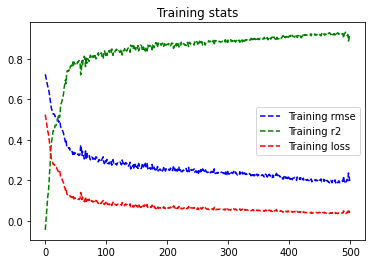

44/44 [==============================] - 2s 4ms/step


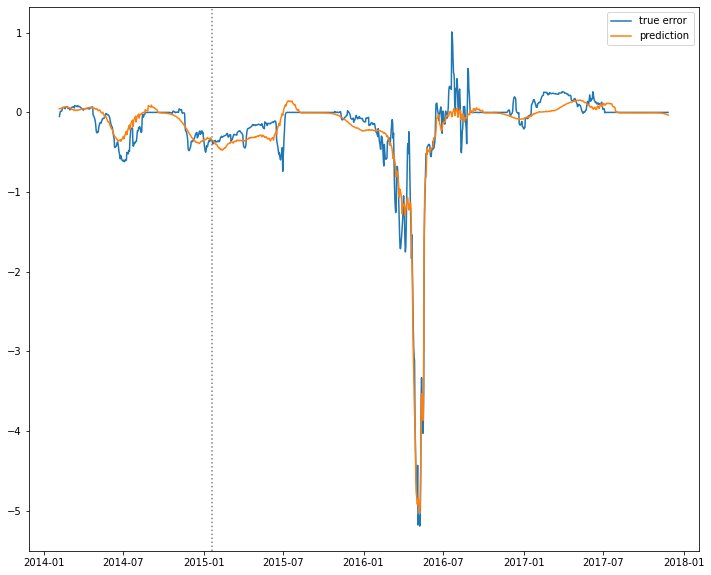

loss : 0.01526285894215107
r_square : 0.6193426251411438
root_mean_squared_error : 0.12354294210672379


In [23]:
# Model trained for 1pt
#datasets["train_1pt_ref"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, exclude_cov=["hsnw00"], keep_fg=keep_fgs, size_around=0)
datasets["train_1pt_ref_lstm"] = all_pt_ds_lstm[point[0], point[1]]

# LSTM model + simple input
model_name = "lstm_ref_simple"
dataset = "train_1pt_ref_lstm"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=500, batch_size=128, print_arch_model=True, print_history=True)

In [19]:
# This computation is a bit long, and crash jupyter kernel (probably too many data in the cache ?)
#model_name = "lstm_ref_simple"
#vals_lstm = eval_all_pts(Xe, models[model_name], all_pt_ds_lstm, mskok)

# This computation can be done with an other script : scr/data_preparation/eval_all_points
# Use : python eval_all_points.py [model_name] [database_name] [path_save] (rootdir is '{rootdir}Calliope /models, /databases and /res
# Ex use : python eval_all_points.py lstm_0_hice_hsnow ds_lstm_0_hice_hsnow vals_lstm_0_hice_hsnow
# We can load the computed data :
with open(f'{rootdir}Calliope/res/vals_lstm_0_hice_hsnow.pickle', "rb") as f:
    vals_lstm = pkl.load(f)

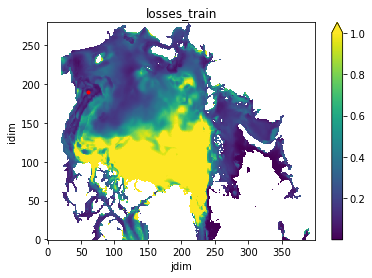

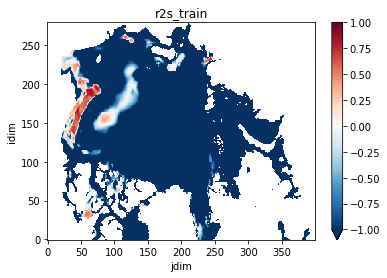

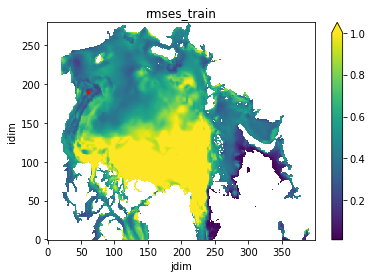

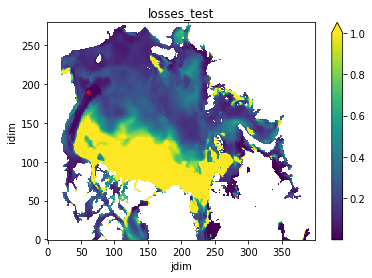

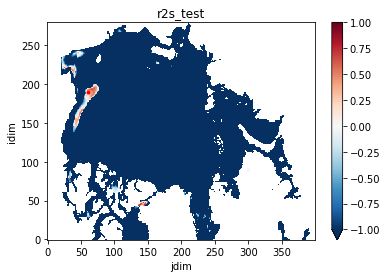

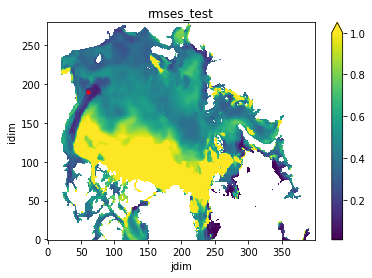

In [24]:
plot_best_cor(vals_lstm, point)

### Train+test  with several points

In [20]:
point = (60, 190) # x, y
point2 =  (205, 130)
point3 =  (60, 200)

In [ ]:
def build_dataset_all_pts(Xe, cov, fgs, lim_idm, lim_jdm, mskok, chrono, size_around=1, keep_cov=[], keep_fgs=[], train_p=3/4, val_p=0, times=[0]):
    """ Build the dataset of all the point in a map (dataset = NaN if the point don't have ice)
        In: 
             Xe          : xarray
             cov         : xarray
             fgs         : dict
             lim_idm     : tuple
             lim_jdm     : tuple
             mskok       : xarray
             chrono      : 
             size_around : int
             keep_cov    : String list
             keep_fgs    : String lsit
             train_p     : float
             val_p       : float
             times       : int list
             
        Out:
            all_dataset : list of list of dataset (dataset = output of build_dataset_1pt function). With all_dataset[i][j], dataset associated to the point [i, j] (idim, jdim)
    """    
    # Np array is better
    cov_npa = to_np_array(cov, keep=keep_cov)
    
    cov_sel = get_area(cov_npa, lim_idm, lim_jdm)
    
    # dims
    t_dim, j_dim, i_dim = cov_sel[list(cov_sel.keys())[0]].shape
    
    # dataset : (i, j)
    all_datasets = [[None for j in range(j_dim)] for i in range(i_dim)]
    
    for j in range(j_dim):
        for i in range(i_dim):
            if not mskok[j, i].values:
                all_datasets[i][j] = np.nan
            else:
                all_datasets[i][j] = build_dataset_1pt([i, j], cov_sel, fgs, Xe[:, j, i], chrono, keep_fg=keep_fgs, size_around=size_around, train_p=train_p, val_p=val_p, times=times)
            
    return all_datasets

In [41]:
def build_dataset_multiple_points(Xe, cov, fgs, points, chrono, keep_cov=[], keep_fgs=[], train_p=3/4, val_p=0, times=[0]):
    """ Build a dataset
    In:
        Xe            : -- error time serie
        cov           : -- covariables time series
        fgs           : -- forcings time series
        points        : -- all points to include in the set : point coord (i, j)
        chrono        : -- chrono over all the test-train period
        keep_cov      : String list -- name of the covariabesl to keep
        keep_fgs      : String list -- name of the forcings to keep
        train_p       : float       -- proportion of data to be kept in the train set
        val_p         : float       -- proportion of data to be kept in the val set (unused now)
        times         : int list    -- if != [0], timestep to keep for each input data (change output dataset shape)
                                    -- if == [0] for DNN network, else for LSTM network
    Out:
        dataset            : dict{"Xtest", "Xtrain", "ytest", "ytrain"}
                            -- Xtrain shape : (ntrain*nb_pts, nb_params) if times == [0]
                                            : (ntrain*nb_pts, len(times), nb_params) else
                            -- ytrain shape : (ntrain*nb_pts)
        (n, ntrain, ntest) : number of data for the various datasets
        rchrono            : time serie dor the final data (same than chrono if times==[0])
    """
    t = cov[keep_cov[0]].shape[0]
    nb_pts = len(points)
    nb_params = len(keep_cov) + len(keep_fgs)
    X = np.empty([t, nb_pts, nb_params])
    Y = np.empty([t, nb_pts])
    
    # Get the data for the points
    for pt in range(nb_pts):
        for ind_f, f in enumerate(keep_cov):
            X[:, pt, ind_f]= cov[f][:, points[pt][1], points[pt][0]]
            
        for ind_f, f in zip(range(len(keep_cov), nb_params), keep_fgs):
            X[:, pt, ind_f]= fgs[f][:, points[pt][1], points[pt][0]]
            
        Y[:, pt] = Xe[:, points[pt][1], points[pt][0]]
            
                
    # If need differents times
    needfutur, needpast = 0, 0
    if max(times)>0:
        needfutur = max(times)
    if min(times)<0:
        needpast = abs(min(times))
        
    # Number of data
    n = X.shape[0] - needpast - needfutur
        
    if len(times) > 1:
        # 3D dataset for LSTM (alltimes,timeslagsgiven, allfeatures) (add several time step in input)
        X2 = np.empty([n, nb_pts, len(times), nb_params])
        for time in range(n):
            for i, ts in enumerate(times):
                X2[time, :, i] = X[needpast+time+ts]
        X = X2
   

    # Train/Test/Validation set
    ntrain = int(n*train_p)
    nval = int(n*val_p)
    ntest = int(n - ntrain - nval)

    
    # Split dataset, train with older years
    # X = (t1_pt1,  ..., tn_pt1, t1_pt2, ..., tn_ptn)
    dataset = dict()
    Xtrain = np.array([X[ntest:, i] for i in range(nb_pts)])
    #Xval = X[]
    #dataset["yval"] = Y[]
    Xtest = np.array([X[:ntest, i] for i in range(nb_pts)])
    dataset["ytest"] = np.reshape(np.array([Y[needpast:ntest+needpast, i] for i in range(nb_pts)]), [nb_pts*ntest])
    
    if len(times) > 1:
        Xtrain = np.reshape(Xtrain, [nb_pts*ntrain, len(times), nb_params])
        Xtest = np.reshape(Xtest, [nb_pts*ntest, len(times), nb_params])
        dataset["ytrain"] = np.reshape(np.array([Y[ntest+needpast:-needfutur, i] for i in range(nb_pts)]), [nb_pts*ntrain])

    else:
        Xtrain = np.reshape(Xtrain, [nb_pts*ntrain, nb_params])
        Xtest = np.reshape(Xtest, [nb_pts*ntest, nb_params])
        dataset["ytrain"] = np.reshape(np.array([Y[ntest:, i] for i in range(nb_pts)]), [nb_pts*ntrain])

    # Add noise to avoid overfitting
    Xtrain = Xtrain + np.random.normal(0, np.std(Xtrain) / 1000, Xtrain.shape)
    dataset["Xtrain"], dataset["Xtest"] = scale_data(Xtrain, Xtest)
    
          
    rchrono = chrono[needpast:-needfutur] if needfutur > 0 else chrono[needpast:]
    
    return dataset, (n, ntrain, ntest), rchrono

In [24]:
# Parameters to keep in the NN dataset
keep_cov=["hice00", "hsnw00"] 
keep_fg=[]
points = [point, point2]

datasets["test2pts_12"] = build_dataset_multiple_points(Xe, np_cov_sel, forcings, points, chrono, keep_cov, keep_fg)
datasets["test2pts_12_lstm"] = build_dataset_multiple_points(Xe, np_cov_sel, forcings, points, chrono, keep_cov, keep_fg, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])


points = [point, point3]

datasets["test2pts_13"] = build_dataset_multiple_points(Xe, np_cov_sel, forcings, points, chrono, keep_cov, keep_fg)
datasets["test2pts_13_lstm"] = build_dataset_multiple_points(Xe, np_cov_sel, forcings, points, chrono, keep_cov, keep_fg, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

pt1
46/46 [==============================] - 1s 937us/step
pt2
46/46 [==============================] - 0s 815us/step


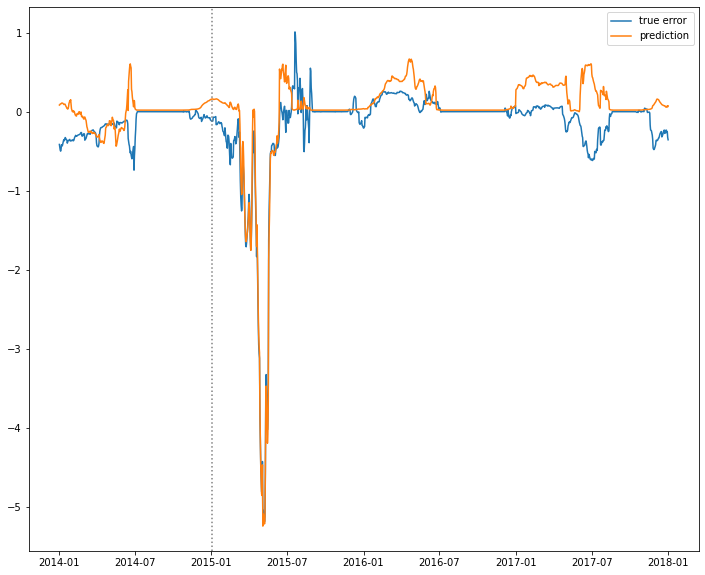

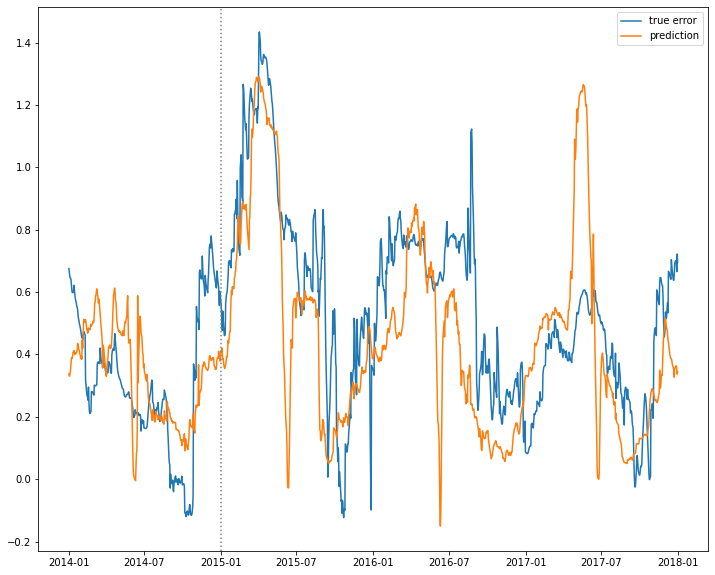

In [46]:
# DNN + points 1/2

# Simple model + more complex input
model_name = "dnn_ds_sevpts_12"
dataset = "test2pts_12"

model = DNN_model(datasets[dataset][0]["Xtrain"].shape[1])
models[model_name] = lauch_train(model, datasets[dataset], epochs=750, batch_size=128, print_arch_model=False, print_history=True, plot_draw=False)

ntr = datasets[dataset][1][1]
nte = datasets[dataset][1][2]
print("pt1")
draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"][:ntr], datasets[dataset][0]["Xtest"][:nte])), np.concatenate((datasets[dataset][0]["ytrain"][:ntr], datasets[dataset][0]["ytest"][:nte])), datasets[dataset][2], nte)
# dict of datasets, one dataset = ({"Xtrain", "ytrain", "Xtest", "ytest"}, (n, ntrain, ntest), chrono)

print("pt2")
draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"][ntr:], datasets[dataset][0]["Xtest"][nte:])), np.concatenate((datasets[dataset][0]["ytrain"][ntr:], datasets[dataset][0]["ytest"][nte:])), datasets[dataset][2], nte)

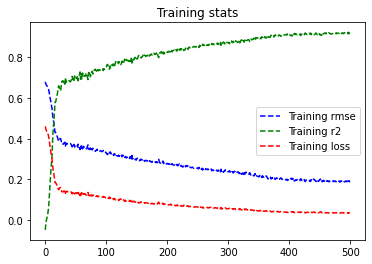

loss : 0.1536262482404709
r_square : -0.35499250888824463
root_mean_squared_error : 0.39195185899734497
pt1
44/44 [==============================] - 1s 3ms/step
pt2
44/44 [==============================] - 0s 3ms/step


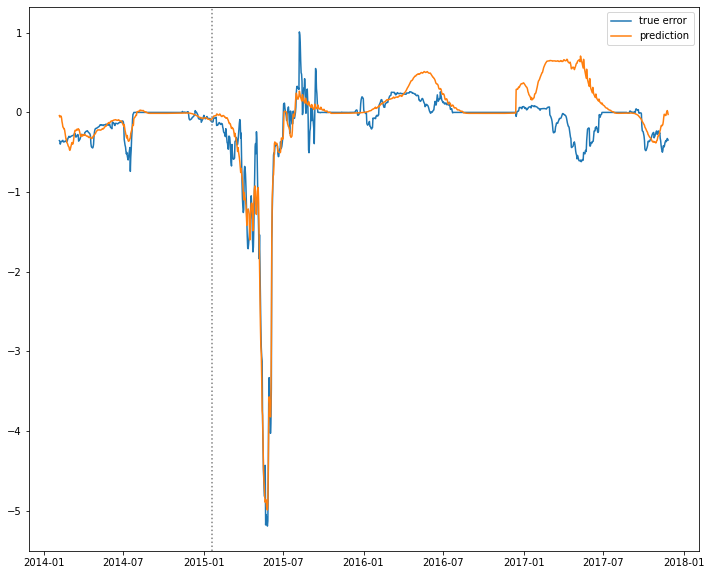

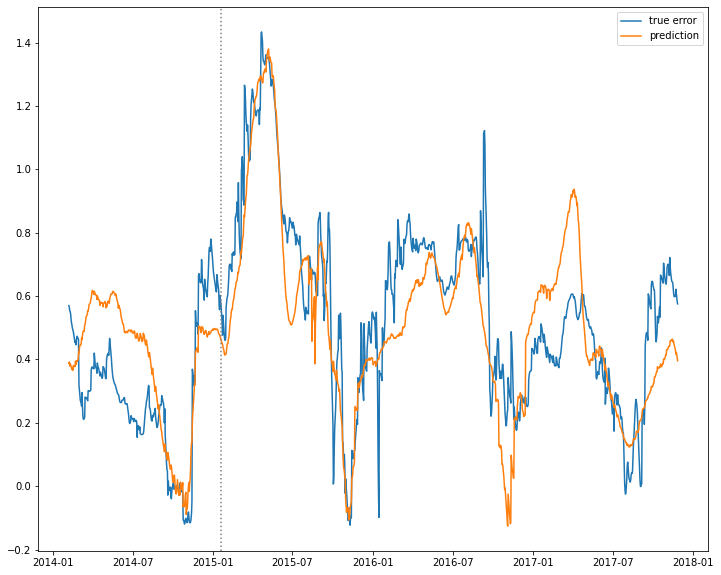

In [48]:
# LSTM + points 1/2

# Simple model + more complex input
model_name = "lstm_ds_sevpts_12"
dataset = "test2pts_12_lstm"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=500, batch_size=128, print_arch_model=False, print_history=True, plot_draw=False)

ntr = datasets[dataset][1][1]
nte = datasets[dataset][1][2]
print("pt1")
draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"][:ntr], datasets[dataset][0]["Xtest"][:nte])), np.concatenate((datasets[dataset][0]["ytrain"][:ntr], datasets[dataset][0]["ytest"][:nte])), datasets[dataset][2], nte)

print("pt2")
draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"][ntr:], datasets[dataset][0]["Xtest"][nte:])), np.concatenate((datasets[dataset][0]["ytrain"][ntr:], datasets[dataset][0]["ytest"][nte:])), datasets[dataset][2], nte)


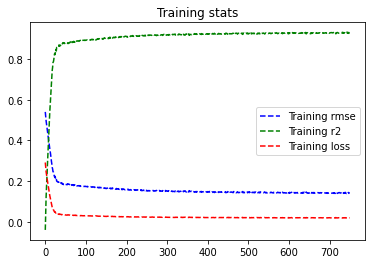

loss : 0.03717273101210594
r_square : -0.3894059658050537
root_mean_squared_error : 0.1928023099899292
pt1
46/46 [==============================] - 0s 831us/step
pt2
46/46 [==============================] - 0s 820us/step


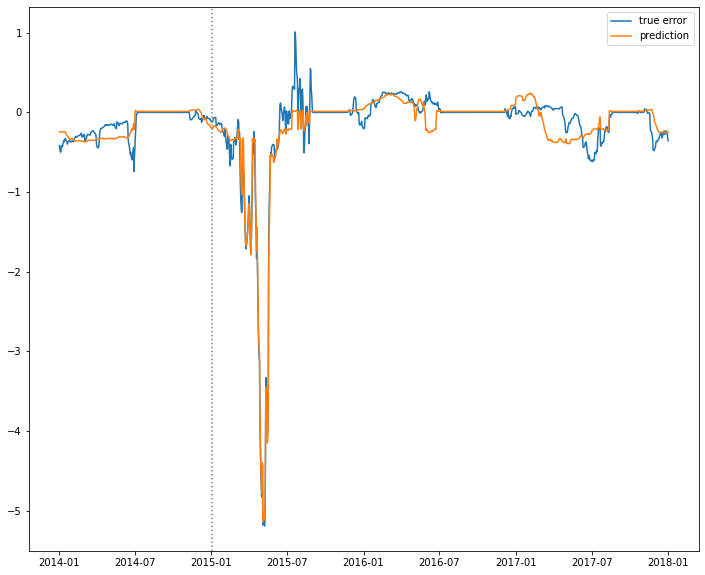

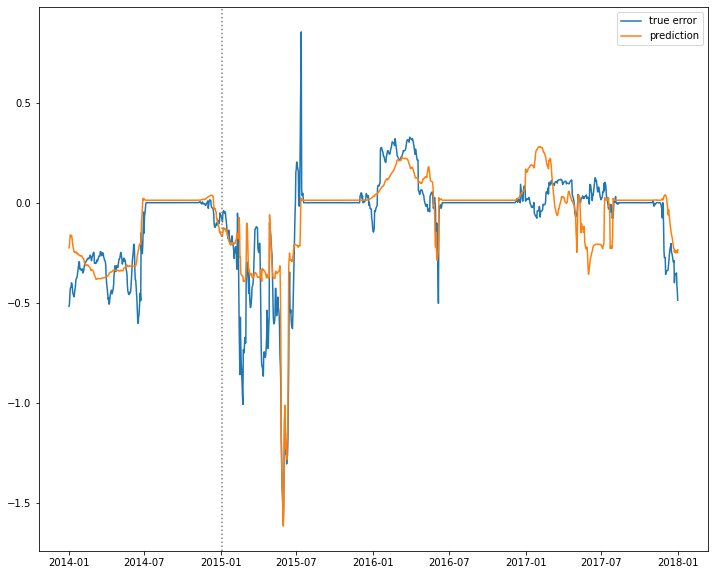

In [49]:
# DNN + points 1/3
model_name = "dnn_ds_sevpts_13"
dataset = "test2pts_13"

model = DNN_model(datasets[dataset][0]["Xtrain"].shape[1])
models[model_name] = lauch_train(model, datasets[dataset], epochs=750, batch_size=128, print_arch_model=False, print_history=True, plot_draw=False)

ntr = datasets[dataset][1][1]
nte = datasets[dataset][1][2]
print("pt1")
draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"][:ntr], datasets[dataset][0]["Xtest"][:nte])), np.concatenate((datasets[dataset][0]["ytrain"][:ntr], datasets[dataset][0]["ytest"][:nte])), datasets[dataset][2], nte)
# dict of datasets, one dataset = ({"Xtrain", "ytrain", "Xtest", "ytest"}, (n, ntrain, ntest), chrono)

print("pt2")
draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"][ntr:], datasets[dataset][0]["Xtest"][nte:])), np.concatenate((datasets[dataset][0]["ytrain"][ntr:], datasets[dataset][0]["ytest"][nte:])), datasets[dataset][2], nte)

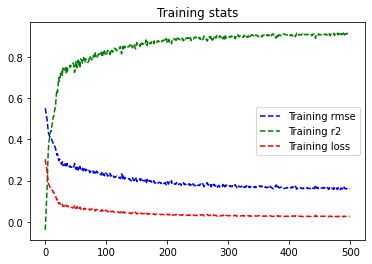

loss : 0.018532030284404755
r_square : 0.4524439573287964
root_mean_squared_error : 0.1361324042081833
pt1
44/44 [==============================] - 1s 3ms/step
pt2
44/44 [==============================] - 0s 3ms/step


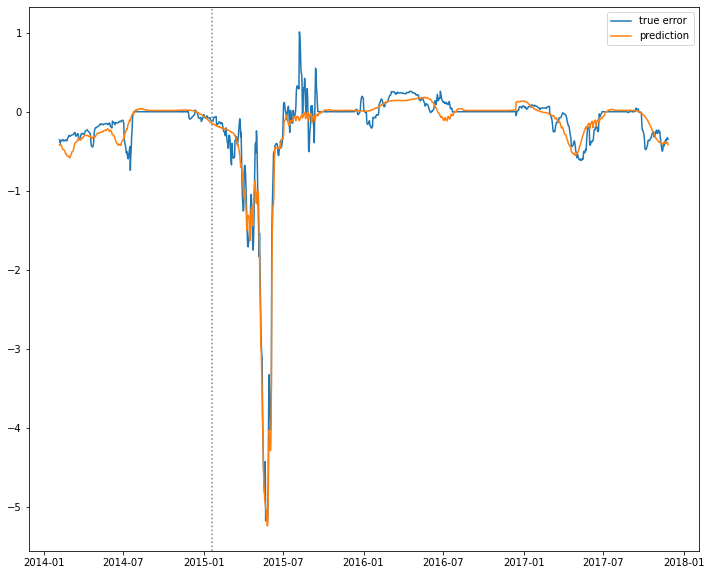

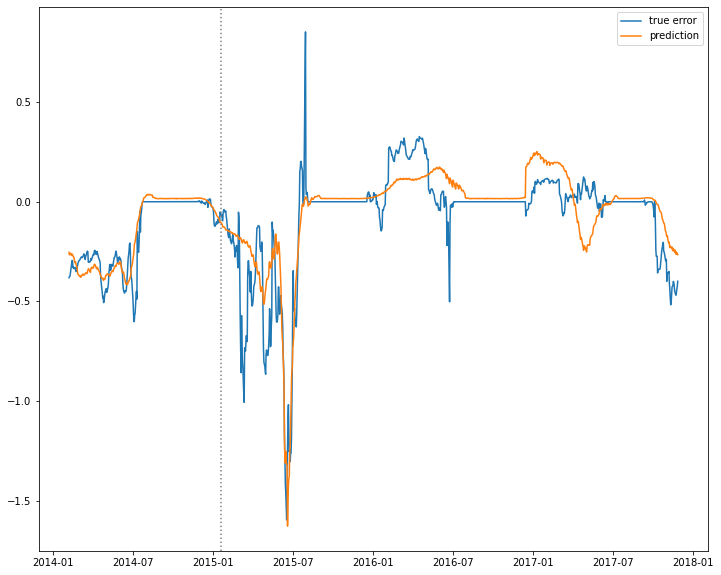

In [50]:
# LSTM + points 1/3

# Simple model + more complex input
model_name = "lstm_ds_sevpts_13"
dataset = "test2pts_13_lstm"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=500, batch_size=128, print_arch_model=False, print_history=True, plot_draw=False)

ntr = datasets[dataset][1][1]
nte = datasets[dataset][1][2]
print("pt1")
draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"][:ntr], datasets[dataset][0]["Xtest"][:nte])), np.concatenate((datasets[dataset][0]["ytrain"][:ntr], datasets[dataset][0]["ytest"][:nte])), datasets[dataset][2], nte)

print("pt2")
draw(models[model_name], np.concatenate((datasets[dataset][0]["Xtrain"][ntr:], datasets[dataset][0]["Xtest"][nte:])), np.concatenate((datasets[dataset][0]["ytrain"][ntr:], datasets[dataset][0]["ytest"][nte:])), datasets[dataset][2], nte)


### Compare global and local approches

In [25]:
point = (60, 190) # x, y
point2 =  (205, 130)
point3 =  (60, 200)

In [26]:
Xe_pt = Xe[:, point[1], point[0]]
Xe_pt2 = Xe[:, point2[1], point2[0]]
Xe_pt3 = Xe[:, point3[1], point3[0]]

In [27]:
# Get global approach results
filepath = "/nird/projects/nird/NS2993K/Calliope/results/pts_reconstruct_PCA"

global_res = []

pts = [1, 2, 3]
for file in os.listdir(filepath):
    if not file.endswith(".png"):
        print(file)
        global_res.append(np.load(f"{filepath}/{file}", allow_pickle=True))

point1_Bias_reconstructed_PCA.npy
point1_SIT_reconstructed_PCA.npy
point3_SIT_reconstructed_PCA.npy
point2_Bias_reconstructed_PCA.npy
point3_Bias_reconstructed_PCA.npy
point2_SIT_reconstructed_PCA.npy


In [28]:
datasets["comp"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, exclude_cov=[], keep_fg=keep_fgs, size_around=3)
datasets["comp_lstm"] = build_dataset_1pt(point, np_cov_sel, forcings, Xe_pt, chrono, keep_fg=keep_fgs, size_around=3, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])
ntst = datasets["comp"][1][2]

2022-09-08 08:52:02.078531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-08 08:52:02.105369: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-08 08:52:02.118457: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-09-08 08:52:02.243179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


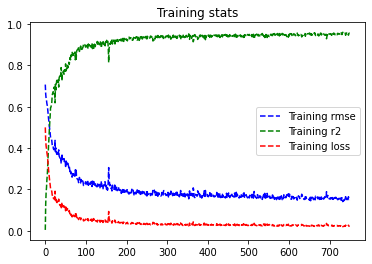

44/44 [==============================] - 1s 4ms/step


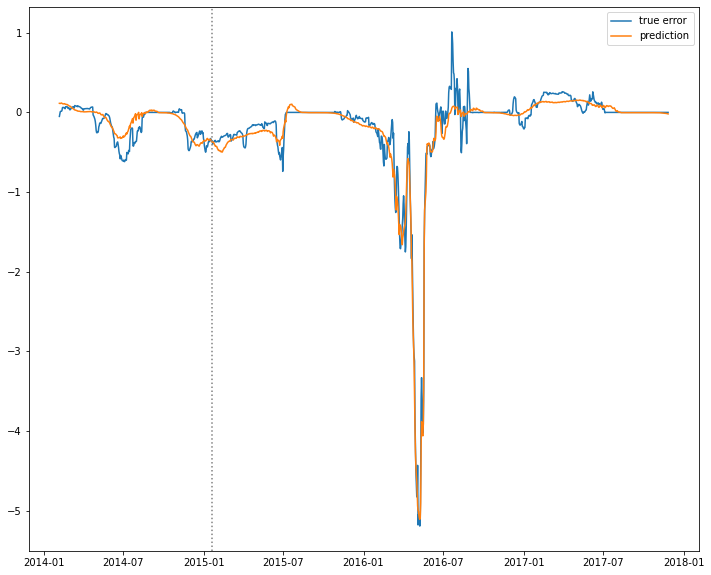

loss : 0.01568426564335823
r_square : 0.6088326573371887
root_mean_squared_error : 0.12523683905601501


In [29]:
model_name = "lstm_comp_pt1"
dataset = "comp_lstm"

model =  LSTM_model(datasets[dataset][0]["Xtrain"].shape[1], datasets[dataset][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[dataset], epochs=750, batch_size=128, print_arch_model=False, print_history=True)

In [30]:
def compare_approaches(model, x, yleo, y, chrono, ntest, twin=False):
    fig, ax = plt.subplots(figsize=(12,10))
    l1 = ax.plot(chrono, y, 'black',label='true error')
    l3 = ax.plot(chrono, yleo, 'r',label='prediction with global approach')
    if twin:
        ax_twin = ax.twinx()
        l2 = ax_twin.plot(chrono, model.predict(x), label='prediction', color='b')
    else:
        l2 = ax.plot(chrono, model.predict(x), 'b',label='prediction with local approach')
    lab1 = l1+l2+l3
    lab2 = [l.get_label() for l in lab1]
    plt.legend(lab1, lab2)
    plt.axvline(x=chrono.iloc[ntest], linestyle='dotted', color='grey', label='train limit')

44/44 [==============================] - 0s 4ms/step


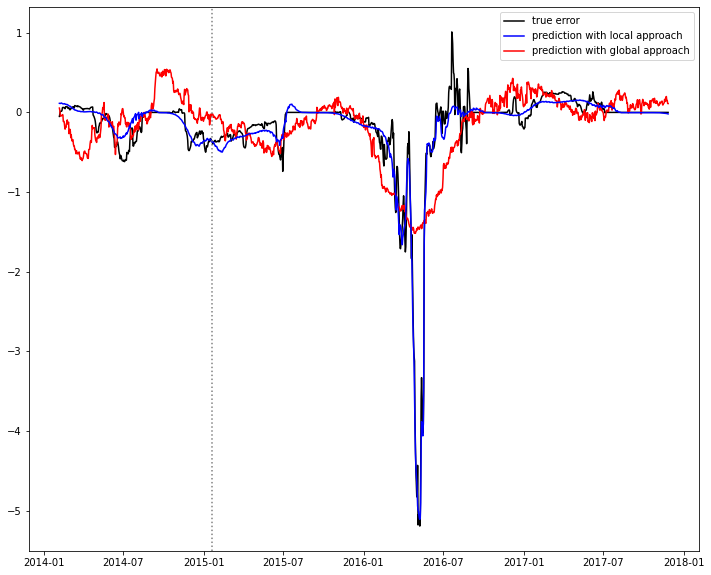

In [35]:
compare_approaches(models[model_name], np.concatenate((datasets[dataset][0]["Xtest"], datasets[dataset][0]["Xtrain"])), global_res[0][35:-35], Xe_pt[35:-35], datasets[dataset][2], datasets[dataset][1][2])

In [33]:
pred = models[model_name].predict(np.concatenate((datasets[dataset][0]["Xtest"], datasets[dataset][0]["Xtrain"])))

44/44 [==============================] - 0s 4ms/step


In [49]:
print("test\n global:", np.corrcoef(global_res[0][:ntst], Xe_pt[:ntst])[0, 1], "\n local:", np.corrcoef(pred.flatten()[:ntst-35], Xe_pt[35:ntst])[0, 1])
print("\n\n train\n global:", np.corrcoef(global_res[0][ntst:], Xe_pt[ntst:])[0, 1], "\n local:", np.corrcoef(pred.flatten()[ntst-35:], Xe_pt[ntst:-35])[0, 1])

test
 global: 0.0792449038325869 
 local: 0.7893031707798694


 train
 global: 0.6465696807727995 
 local: 0.9824129918354056


#### Bonus (mess with differents models)

In [39]:
def get_area(data, lim_idm, lim_jdm, exclude=[]):
    """ Keep only data for given geographical zone
    In:
        data        : dict or xarray.core.dataset.Dataset -- Data to process
        lim_idm     : tuple                               -- limits of the geographical area to be preserved (following axes x)
        lim_jdm     : tuple                               -- limits of the geographical area to be preserved (following axes y)
        index_mask  : numpy.ndarray                       -- mask to apply for nonan if needed (ex: for forcings nonan to keep)
        
    Out:
        X_sel       : dict -- key = field name, value = (t, y, x) array, data array restricted to the given geographical area and mean over time
        X_sel_nonan : dict -- same than Xm_sel without NaN values
    """
    
    if type(data) is dict:
        fields = [f for f in data.keys() if f not in exclude]
    else:
        fields = [f for f in data.data_vars if f not in exclude]

    X_sel = dict()
    t = data[fields[0]].shape[0]
    
    for field in fields:
        if type(data) is dict:
            X_sel[field] = np.empty([t, lim_jdm[1]-lim_jdm[0], lim_idm[1]-lim_idm[0]])
            for i, coordi in enumerate(range(lim_idm[0], lim_idm[1])):
                for j, coordj in enumerate(range(lim_jdm[0], lim_jdm[1])):
                    X_sel[field][:, j, i] = np.reshape(data[field][:, coordj, coordi], (t))
        else:
            X_sel[field] = data[field].sel(jdim=slice(*lim_jdm),idim=slice(*lim_idm)).values
        
    return X_sel




def pick_area(point, size_around=1, exclude=[]):
    """ Select a point an the points around (1 point if size_around=0, 9points if size_around=1...)
    """
    # Covariables
    lim_i = (lim_idm[0] + point[0] - size_around, lim_idm[0] + point[0] + size_around + 1)
    lim_j = (lim_jdm[0] + point[1] - size_around, lim_jdm[0] + point[1] + size_around + 1)
    Xf_sel_cov = get_area(nc_f, lim_i, lim_j, exclude)


    # Forcings
    lim_i = (point[0] - size_around, point[0] + size_around + 1)
    lim_j = (point[1] - size_around, point[1] + size_around + 1)
    X_sel_fgs = get_area(forcings, lim_i, lim_j)
    
    return Xf_sel_cov, X_sel_fgs

In [40]:
def select_input(Xf_sel_cov, X_sel_fgs, allpoints=True, separated_space_dim=False, keep_cov=None, keep_fgs=None):
    """ Stacks all needed input values for nn input
        Input:
            - Xf_sel_cov          : dict of numpy.ndarray           -- shape (t, x, y)
            - X_sel_fgs           : dict of numpy.ndarray           -- shape (t, x, y)
            - allpoints           : boolean                         -- if True use all points given, else use only the middle one
            - separated_space_dim : boolean                         -- if True, output shape is (timestep, x, y, features), else it's (timestep, features) (features stack all points in the 2e case)
            - keep_cov            : String list                     -- list with covariables fields to keep on Xf_sel_cov
            - keep_fgs            : String list                     -- list with forcings fields to keep on X_sel_fgs

        Output:
            - X : numpy.ndarray 
                -- shape:
                    if separated_space_dim: (timestep, x, y, features)
                    else: (timestep, features) (features stack all points :x*y*cov*fgs)

    """
    points = Xf_sel_cov['hice00'].shape[1:]
    t = Xf_sel_cov['hice00'].shape[0]
    if allpoints:
        nb_pts = points[0]*points[1]
    else:
        nb_pts = 1
        t_point = (points[0] // 2, points[1] // 2)
        
    if keep_cov != None:
        fields_cov = keep_cov
    else:
        fields_cov = Xf_sel_cov.keys()
        
    if keep_fgs != None:
        fields_fgs = keep_fgs
    else:
        fields_fgs = X_sel_fgs.keys()
        
    if separated_space_dim and allpoints:
        #dim = (t, points[0], points[1], 1 + len(fields_cov) + len(fields_fgs)) #(timestep, x, y, features)
        dim = (t, points[0], points[1], len(fields_cov) + len(fields_fgs)) #(timestep, x, y, features)
        X = np.empty(dim)
        for time in range(t):
            all_cov = np.reshape(np.array([Xf_sel_cov[f][time] for f in fields_cov]), (points[0], points[1], len(fields_cov)))
            all_fgs = np.reshape(np.array([X_sel_fgs[f][time] for f in fields_fgs]), (points[0], points[1], len(fields_fgs)))
            #xf = np.reshape(Xf[time].values, (points[0], points[1], 1))
            if all_cov.size == 0 and all_fgs.size > 0:
                X[time] = all_fgs
                #X[time] = np.concatenate((xf, all_fgs), axis=2)
            elif all_fgs.size == 0 and all_cov.size > 0:
                X[time] = all_cov
                #X[time] = np.concatenate((xf, all_cov), axis=2)
            else:
                X[time] = np.concatenate((all_cov, all_fgs), axis=2)
                #X[time] = np.concatenate((xf, all_cov, all_fgs), axis=2)
        
    else:
        #dim = (t, 1 + len(fields_cov)*nb_pts + len(fields_fgs)*nb_pts)  #(timestep, features) : feature for all space points on features
        dim = (t, len(fields_cov)*nb_pts + len(fields_fgs)*nb_pts)  #(timestep, features) : feature for all space points on features
        X = np.empty(dim)
        for time in range(t):
            if allpoints:
                all_cov = np.array([Xf_sel_cov[f][time] for f in fields_cov]).flatten()
                all_fgs = np.array([X_sel_fgs[f][time] for f in fields_fgs]).flatten()
            else:
                all_cov = np.array([Xf_sel_cov[f][time][t_point] for f in fields_cov]).flatten()
                all_fgs = np.array([X_sel_fgs[f][time][t_point] for f in fields_fgs]).flatten()
                
            if all_cov.size == 0 and all_fgs.size > 0:
                X[time] = all_fgs
                #X[time] = np.concatenate((np.array([Xf[time]]),all_fgs))
            elif all_fgs.size == 0 and all_cov.size > 0:
                X[time] = all_cov
                #X[time] = np.concatenate((np.array([Xf[time]]), all_cov))
            else:
                X[time] = np.concatenate((all_cov, all_fgs))  
                #X[time] = np.concatenate((np.array([Xf[time]]), all_cov, all_fgs))  
            
    return X

In [41]:
def scale_data(train_data, test_data):
    max_val = train_data.max()
    min_val = train_data.min()
    train_scaled = (train_data - min_val) / (max_val - min_val)
    test_scaled = (test_data - min_val) / (max_val - min_val)
    return train_scaled, test_scaled

def build_dataset2(X, y, chrono, train_p=3/4, times=[0]):
    # Dataset size, depending past and future values needed
    needfutur, needpast = 0, 0
    if max(times)>0:
        needfutur = max(times)
    if min(times)<0:
        needpast = abs(min(times))
        
    n = X.shape[0] - needpast - needfutur
    ntrain = int(n*train_p)
    ntest = n - ntrain
    
    if len(times) > 1:
        # 3D dataset for LSTM (alltimes, timeslagsgiven, allfeatures) (add several time step in input)
        X2 = np.empty([n, len(times)]+list(X.shape[1:]))
        for time in range(n):
            for i, ts in enumerate(times):
                X2[time, i] = X[needpast+time+ts]
        X = X2
        
        
    # Split dataset, train with older years
    dataset = dict()
    Xtrain = X[ntest:]
    dataset["ytrain"] = y[needpast+ntest:-needfutur] if needfutur != 0 else y[needpast+ntest:]
    Xtest = X[:ntest]
    dataset["ytest"] = y[needpast:needpast+ntest]
    
    # Add noise to avoid overfitting
    Xtrain = Xtrain + np.random.normal(0, np.std(Xtrain) / 1000, Xtrain.shape)
    
    
    # Normalize each set (avoid to normalize test with train data)
    #dataset["Xtrain"] = (dataset["Xtrain"]  - np.mean(dataset["Xtrain"] )) / np.std(dataset["Xtrain"]) 
    #dataset["Xtest"] = (dataset["Xtest"]  - np.mean(dataset["Xtest"] )) / np.std(dataset["Xtest"]) 
    
    dataset["Xtrain"], dataset["Xtest"] = scale_data(Xtrain, Xtest)

    #print(f'Size of the training set: {ntrain} days')
    #print(f'Size of the test set: {ntest} days')
    
    #return Xtrain, Xtest, ytrain, ytest, ntest, ntrain
    rchrono = chrono[needpast:-needfutur] if needfutur > 0 else chrono[needpast:]
    return dataset, (n, ntrain, ntest), rchrono

In [46]:
# input_shape : (time_step, rows, cols, features)
def ConvLSTM_model(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3), return_sequences = True, input_shape = input_shape))
    model.add(BatchNormalization())
    #model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(0.1))

    model.add(ConvLSTM2D(filters=10, kernel_size=(1, 1), return_sequences = True))
    model.add(BatchNormalization())
    #model.add(MaxPooling3D(pool_size=(1, 3, 3)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    #model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()]) #TODO: r2 metrics wrong shape, should rewrite it

    return model

In [28]:
def plot_training_analysis2(history):
    loss = history.history['loss']
    rmse = history.history['root_mean_squared_error']

    epochs = range(len(loss))

    plt.plot(epochs, rmse, 'b', linestyle="--",label='Training rmse')
    plt.plot(epochs, loss, 'r', linestyle="--",label='Training loss')
    plt.title('Training stats')
    plt.legend()

    plt.show()
    

def lauch_train2(model, dataset, epochs=250, batch_size=128, print_arch_model=True, print_history=True, plot_draw=True):

    if print_arch_model:
        model.summary()
        plt.show()
        
    history = model.fit(dataset[0]["Xtrain"], dataset[0]["ytrain"], epochs=epochs, batch_size=batch_size, verbose=0)

    if print_history:
        plot_training_analysis2(history)
        plt.show()

    if plot_draw:
        draw(model, np.concatenate((dataset[0]["Xtest"], dataset[0]["Xtrain"])), np.concatenate((dataset[0]["ytest"], dataset[0]["ytrain"])), dataset[2], dataset[1][2])
        plt.show()

    print_res(model, dataset)
    
    return model

In [ ]:
exclude = ['longitude', 'latitude', 'dx', 'dy', 'depth', 'fyear', 'fice00', 'htndncy00', 'albedo00', 'emnp00', 'salflx00', 'spdice00', 'surflx00', 'surflxs00', 'swflx00', 'saln01', 'temp01', 'kinetic01', 'taux00', 'tauy00', 'tauxi00', 'tauyi00', 'ubavg00', 'vbavg00', 'uice00', 'utot01', 'vtot01']
Xf_sel_cov, X_sel_fgs = pick_area(point, size_around=3, exclude=exclude)

In [55]:
xs = select_input(Xf_sel_cov, X_sel_fgs, allpoints=True, separated_space_dim=True, keep_cov=["hice00", "hsnw00"], keep_fgs=None)
datasets["multipt"] =  build_dataset2(xs, Xe_pt, chrono, train_p=3/4, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 11, 5, 5, 20)      18080     
                                                                 
 batch_normalization_6 (Batc  (None, 11, 5, 5, 20)     80        
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 11, 5, 5, 20)      0         
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 11, 5, 5, 10)      1240      
                                                                 
 batch_normalization_7 (Batc  (None, 11, 5, 5, 10)     40        
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, 11, 5, 5, 10)     

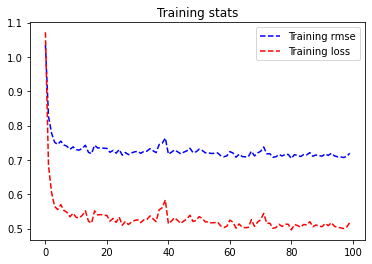

44/44 [==============================] - 1s 7ms/step


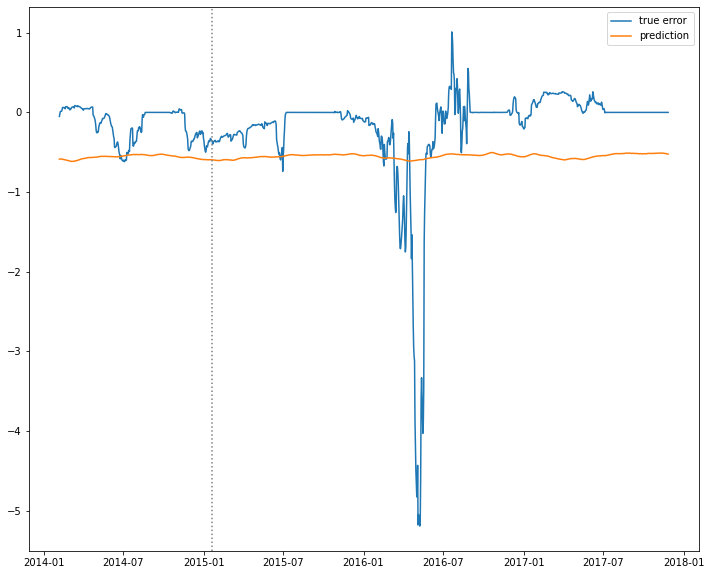

loss : 0.21930037438869476
root_mean_squared_error : 0.4682951867580414


In [56]:
# ConvLSTM
model_name = "convlstm"
dataset = "multipt"

model = ConvLSTM_model(datasets[dataset][0]["Xtrain"].shape[1:])
models[model_name] = lauch_train2(model, datasets[dataset], epochs=100, batch_size=128, print_arch_model=True, print_history=True)

In [50]:
def CNN_model(input_shape):

    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=input_shape, activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    
    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])


    return model

In [52]:
# More complex input
Xf_sel_cov2, X_sel_fgs2 = pick_area(point, size_around=4, exclude=exclude)

#xs["9pt_hsnw"] = select_input(Xf_sel_cov, X_sel_fgs, keep_cov=["hice00", "hsnw00"], keep_fgs=[])
xs = select_input(Xf_sel_cov2, X_sel_fgs2, keep_cov=["hice00"], keep_fgs=[], separated_space_dim=True)

datasets["9pts_cnn_dataset"] =  build_dataset2(xs, Xe_pt, chrono, train_p=3/4, times=[0])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 32)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 dropout_9 (Dropout)         (None, 3, 3, 32)          0         
                                                                 
 flatten_3 (Flatten)         (None, 288)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               147968    
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                      

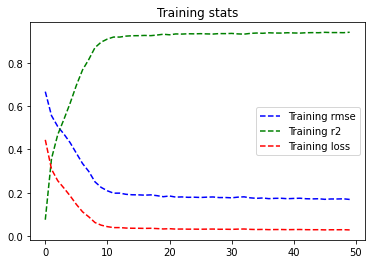

46/46 [==============================] - 0s 2ms/step


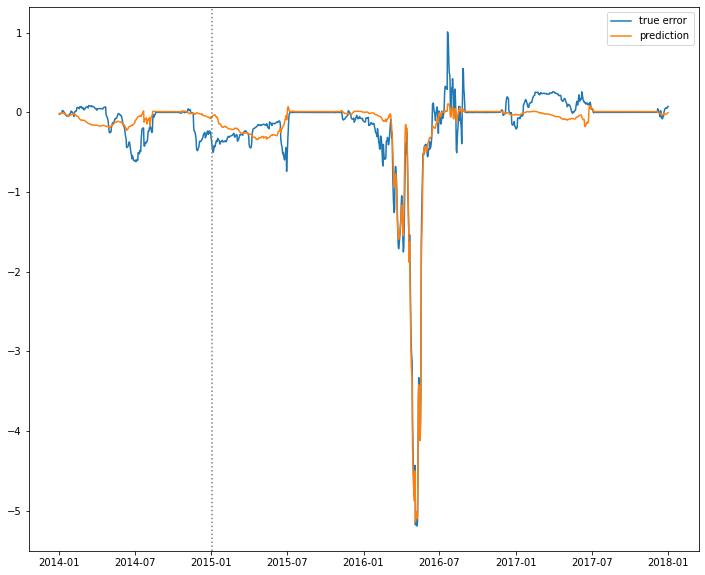

loss : 0.038126908242702484
r_square : -0.06622064113616943
root_mean_squared_error : 0.1952611356973648


In [53]:
# CNN
model_name = "cnn_model"
dataset = "9pts_cnn_dataset"

model = CNN_model(datasets[dataset][0]["Xtrain"].shape[1:])
models[model_name] = lauch_train(model, datasets[dataset], epochs=50, batch_size=128, print_arch_model=True, print_history=True)